In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplo

t as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [2]:
train_df=pd.read_csv('train.csv')
train_df=train_df.set_index("CHARTTIME")
val_df=pd.read_csv('validation.csv')
val_df=val_df.set_index("CHARTTIME")
test_df=pd.read_csv('test.csv')
test_df=test_df.set_index('CHARTTIME')

In [3]:
print(train_df.columns)
print(train_df.shape)

Index(['HADM_ID', 'SUBJECT_ID', 'GENDER', 'AGE', 'Admission Weight (Kg)',
       'Height (cm)', 'Heart Rate', 'Non Invasive Blood Pressure diastolic',
       'Non Invasive Blood Pressure mean',
       'Non Invasive Blood Pressure systolic', 'Respiratory Rate', 'stroke'],
      dtype='object')
(207408, 12)


In [4]:
#Imports
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense,LSTM,Dropout,Conv1D,MaxPooling1D,Flatten,Bidirectional,TimeDistributed,Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow.keras as keras
warnings.filterwarnings('ignore')
FEATURES=10
TIMESTEPS=4
OUTPUT=1
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [5]:
from sklearn.preprocessing import StandardScaler,RobustScaler
def static_scale(df):
    data=df.copy()
    scaler=RobustScaler()
    static_cols=["AGE",'Admission Weight (Kg)',"Height (cm)"]
    data[static_cols]=scaler.fit_transform(data[static_cols])
    return data,scaler

In [6]:
from sklearn.preprocessing import StandardScaler,RobustScaler
from tqdm import tqdm
def dynamic_scale(df):
    final_df=pd.DataFrame()
    cols=['Heart Rate',
                  'Non Invasive Blood Pressure diastolic', 'Non Invasive Blood Pressure mean',
                 'Non Invasive Blood Pressure systolic', 'Respiratory Rate']
    for hadm in tqdm(df['HADM_ID'].unique()):
        scaler=RobustScaler()
        #extract the dataframe
        hadm_df=df[df['HADM_ID']==hadm]
        #scale the float cols
        hadm_df[cols]=scaler.fit_transform(hadm_df[cols])
#         print(hadm_df)
        final_df = pd.concat([final_df,hadm_df])
    return final_df

In [7]:
static_cols=["AGE",'Admission Weight (Kg)',"Height (cm)"]
scaled_train,scaler=static_scale(train_df)
val_df[static_cols]=scaler.transform(val_df[static_cols])
test_df[static_cols]=scaler.transform(test_df[static_cols])

In [8]:
scaled_train=dynamic_scale(scaled_train)
val_df=dynamic_scale(val_df)
test_df=dynamic_scale(test_df)

100%|██████████| 216/216 [00:00<00:00, 256.33it/s]


In [9]:
#apply this function for eacxh unique admission
#so we won't mix timestamps from different admission in the same training sequence
def create_window(df):
    n_observation=4
    n_forecast=2
    n_target=1
    X,y=[],[]
    for adm_id in tqdm(df['HADM_ID'].unique()):
        data=df[df['HADM_ID']==adm_id]
#         target_cols=["stroke"]
#         target_df=data[target_cols]
    #     data.drop(target_cols,axis=1,inplace=True)
        for i in range(len(data)-8):
            X.append(data.iloc[i:i+n_observation,2:])
            y.append(data.iloc[i+n_observation+n_forecast:i+n_observation+n_forecast+n_target,-1])
    return np.array(X),np.array(y)

- apply changes for the models args function 

In [10]:
def build_lstm(timesteps,feats,output):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(timesteps, feats)))
    model.add(LSTM(32))
    model.add(Dense(output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])
    print(model.summary())
    return model

In [11]:
def build_cnn(timesteps,feats,output):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps,feats)))
    #model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
    
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])
    print(model.summary())
    return model
    

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense
def build_gru(timesteps, feats, output):
    model = Sequential()
    model.add(Bidirectional(GRU(64, return_sequences=True), input_shape=(timesteps, feats)))
    model.add(GRU(32))
    model.add(Dense(output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])
    print(model.summary())
    return model


In [ ]:
from tensorflow.keras.layers import ConvLSTM2D
def build_convlstm(timesteps, feats, output):
    model = Sequential()

In [28]:
import os
early_stopping = keras.callbacks.EarlyStopping(monitor="val_prc", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_prc", patience=5)
def create_checkpoint_callback(model_name):
    # Ensure the 'checkpoints/' directory exists
    if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')
    
    # Create a unique filename based on the model name
    filename = f"checkpoints/{model_name}_best_model.h5"
    
    checkpoint_callback = ModelCheckpoint(
        filename,                       # Dynamic path to save the model
        monitor='val_prc',              # Metric to monitor
        mode='max',                     # Since you want to maximize the PRC
        save_best_only=True,            # Only save the best model
        verbose=1                       # Log when a better model is found
    )
    return checkpoint_callback
#checkpoint = keras.callbacks.ModelCheckpoint('./checkpoint', monitor='val_prc',save_best_only=True, mode='max')
#how to call it
# model_1_callback = create_checkpoint_callback("model_1")
# model.fit(
#     x_train, y_train,
#     validation_data=(x_val, y_val),
#     epochs=epochs,
#     batch_size=batch_size,
#     callbacks=[model_1_callback]
# )

### Custom model separate dynamic and static feats

In [12]:
#apply necessary changes 
# RNN + SLP
n_static=4
n_timesteps=4
n_dynamic=6
n_output=1

#Define input layer
recurrent_input = Input(shape=(n_timesteps,n_dynamic),name="TIMESERIES_INPUT")
static_input = Input(shape=(n_static, ),name="STATIC_INPUT")

# RNN Layers
# layer - 1
rec_layer_one = Bidirectional(LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),return_sequences=True),name ="BIDIRECTIONAL_LAYER_1")(recurrent_input)
rec_layer_one = Dropout(0.1,name ="DROPOUT_LAYER_1")(rec_layer_one)
# layer - 2
rec_layer_two = Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)),name ="BIDIRECTIONAL_LAYER_2")(rec_layer_one)
rec_layer_two = Dropout(0.1,name ="DROPOUT_LAYER_2")(rec_layer_two)

# SLP Layers
static_layer_one = Dense(64,  kernel_regularizer=l2(0.001),  activation='relu',name="DENSE_LAYER_1")(static_input)
# Combine layers - RNN + SLP
combined = Concatenate(axis= 1,name = "CONCATENATED_TIMESERIES_STATIC")([rec_layer_two,static_layer_one])
combined_dense_two = Dense(64, activation='relu',name="DENSE_LAYER_2")(combined)
output = Dense(n_output,activation='sigmoid',name="OUTPUT_LAYER")(combined_dense_two)

# Compile ModeL
model = keras.Model(inputs=[recurrent_input,static_input],outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 TIMESERIES_INPUT (InputLayer)  [(None, 4, 6)]       0           []                               
                                                                                                  
 BIDIRECTIONAL_LAYER_1 (Bidirec  (None, 4, 256)      138240      ['TIMESERIES_INPUT[0][0]']       
 tional)                                                                                          
                                                                                                  
 DROPOUT_LAYER_1 (Dropout)      (None, 4, 256)       0           ['BIDIRECTIONAL_LAYER_1[0][0]']  
                                                                                                  
 BIDIRECTIONAL_LAYER_2 (Bidirec  (None, 128)         164352      ['DROPOUT_LAYER_1[0][0]']  

In [5]:
!pip install  pydot

In [13]:
from keras.utils.vis_utils import plot_model
print(plot_model(model, to_file='./model_architecture.png', show_shapes=True, show_layer_names=True))


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
None


In [13]:
def plot(history,metric):
    val="val_"+metric
    df=pd.DataFrame(history.history)[[metric,val]]
    df.plot(figsize=(10,6))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()


In [14]:
def clean_preds(model,data):
    real_predictions=[]
    predictions=model.predict(data)
    for pred in predictions:
        if pred > 0.5:
            real_predictions.append(1)
        else:
            real_predictions.append(0)
    return np.array(real_predictions)
        

In [15]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
def plot_cm (real,preds):
    plt.figure(figsize=(6,6))
    cm = confusion_matrix(real,preds)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in  cm.flatten()] 
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in  zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot=labels,fmt="",cmap='Blues')
    print(classification_report(real, preds))
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
#     plt.title('STEP 1')

In [16]:
neg,pos=np.bincount(train_df['stroke'])
total=neg+pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 207408
    Positive: 6848 (3.30% of total)

Weight for class 0: 0.52
Weight for class 1: 15.14


In [17]:
X_train,y_train=create_window(scaled_train)
X_val,y_val=create_window(val_df)
X_test,y_test=create_window(test_df)
print(X_train.shape," ",y_train.shape)
print(X_val.shape," ",y_val.shape)
print(X_test.shape," ",y_test.shape)

100%|██████████| 216/216 [00:04<00:00, 45.33it/s]


(194376, 4, 10)   (194376, 1)
(24153, 4, 10)   (24153, 1)
(24164, 4, 10)   (24164, 1)


In [35]:
#extracting static feats
X_train_static=X_train[:, 0, :4]
X_val_static=X_val[:,0,:4]
X_test_static=X_test[:,0,:4]

In [36]:
# fit network
#training for 30 EPOCHS
history =  model.fit([X_train[:,:,4:],X_train_static],y_train,
epochs=30,
batch_size=32,
validation_data=([X_val[:,:,4:],X_val_static],y_val),
                    class_weight=class_weight)

Epoch 1/30
6075/6075 [==============================] - 117s 17ms/step - loss: 0.5522 - accuracy: 0.8981 - precision: 0.1882 - recall: 0.6560 - auc: 0.8277 - prc: 0.3638 - val_loss: 0.3775 - val_accuracy: 0.9360 - val_precision: 0.3892 - val_recall: 0.7289 - val_auc: 0.8550 - val_prc: 0.5941
Epoch 2/30
6075/6075 [==============================] - 104s 17ms/step - loss: 0.4730 - accuracy: 0.9161 - precision: 0.2261 - recall: 0.6657 - auc: 0.8416 - prc: 0.3884 - val_loss: 0.5459 - val_accuracy: 0.8591 - val_precision: 0.2088 - val_recall: 0.7582 - val_auc: 0.8553 - val_prc: 0.5707
Epoch 3/30
6075/6075 [==============================] - 105s 17ms/step - loss: 0.4648 - accuracy: 0.9184 - precision: 0.2326 - recall: 0.6695 - auc: 0.8454 - prc: 0.3858 - val_loss: 0.5210 - val_accuracy: 0.8491 - val_precision: 0.1988 - val_recall: 0.7711 - val_auc: 0.8579 - val_prc: 0.5655
Epoch 4/30
6075/6075 [==============================] - 105s 17ms/step - loss: 0.4565 - accuracy: 0.9117 - precision: 0.2

Epoch 29/30
6075/6075 [==============================] - 103s 17ms/step - loss: 0.4282 - accuracy: 0.9052 - precision: 0.2116 - recall: 0.7158 - auc: 0.8764 - prc: 0.4178 - val_loss: 0.4448 - val_accuracy: 0.8567 - val_precision: 0.2040 - val_recall: 0.7473 - val_auc: 0.8494 - val_prc: 0.5449
Epoch 30/30
6075/6075 [==============================] - 104s 17ms/step - loss: 0.4281 - accuracy: 0.9069 - precision: 0.2152 - recall: 0.7177 - auc: 0.8772 - prc: 0.4129 - val_loss: 0.4348 - val_accuracy: 0.8815 - val_precision: 0.2405 - val_recall: 0.7509 - val_auc: 0.8531 - val_prc: 0.5231


              precision    recall  f1-score   support

           0       0.98      0.87      0.92     23394
           1       0.13      0.56      0.21       770

    accuracy                           0.86     24164
   macro avg       0.56      0.72      0.57     24164
weighted avg       0.96      0.86      0.90     24164



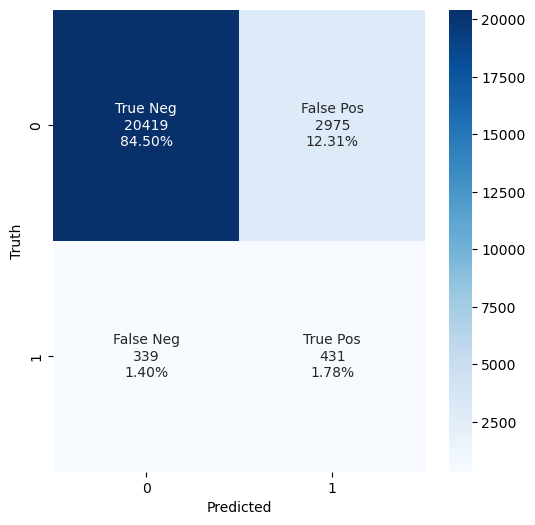

In [37]:
plot_cm(y_test,clean_preds(model,[X_test[:,:,4:],X_test_static]))

In [38]:
model.evaluate([X_test[:,:,4:],X_test_static],y_test)

756/756 [==============================] - 7s 9ms/step - loss: 0.4448 - accuracy: 0.8629 - precision: 0.1265 - recall: 0.5597 - auc: 0.7468 - prc: 0.2502


[0.4447867274284363,
 0.8628538250923157,
 0.1265413910150528,
 0.5597402453422546,
 0.7468172311782837,
 0.25023192167282104]

In [19]:
#define metrics_list global varibale
metrics_list=['loss',"accuracy","recall","precision","auc","prc"]

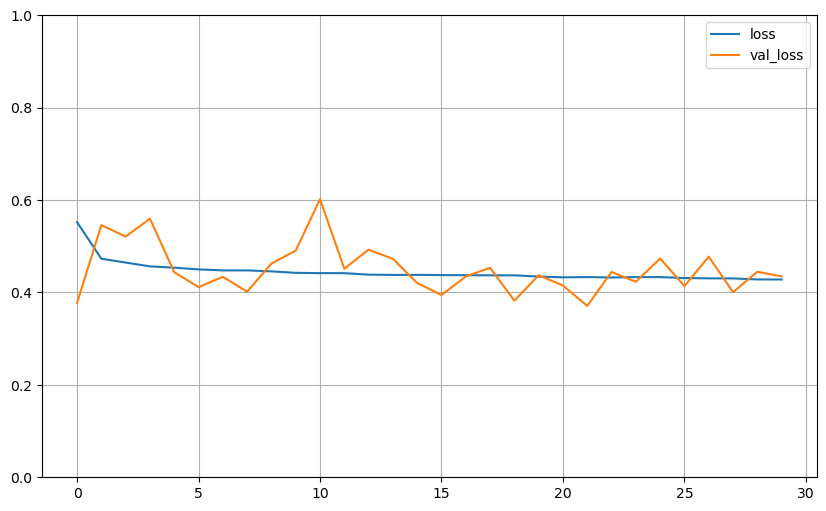

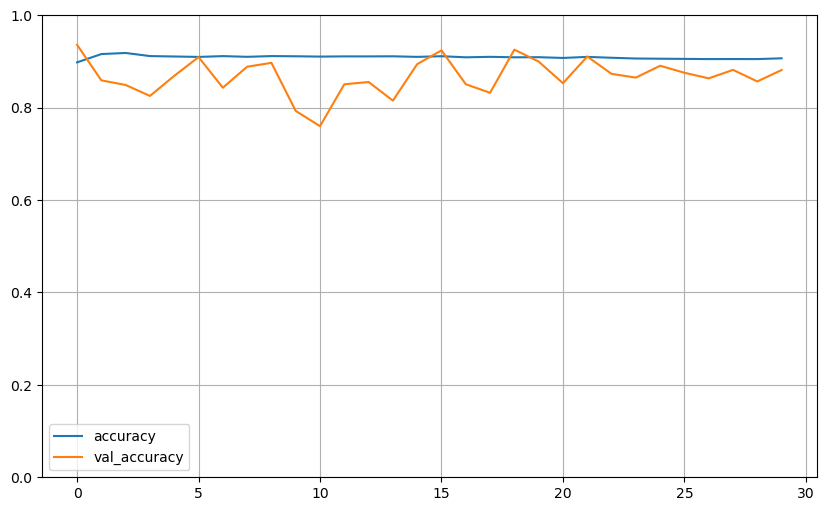

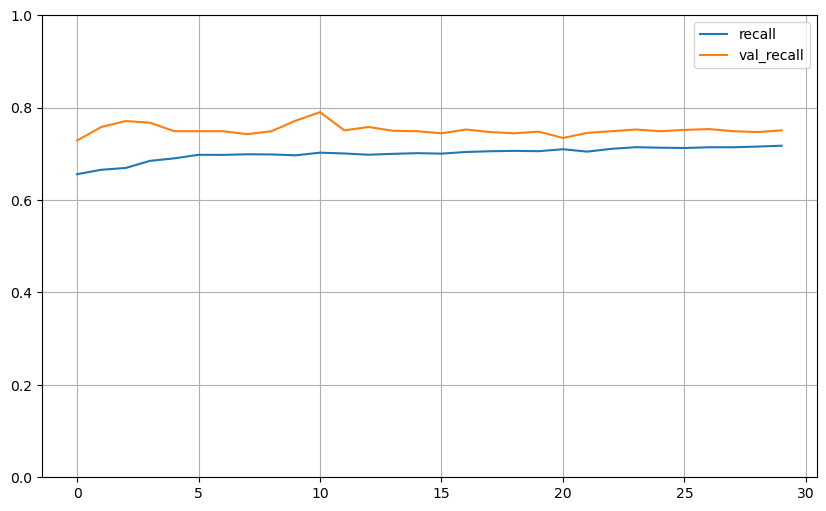

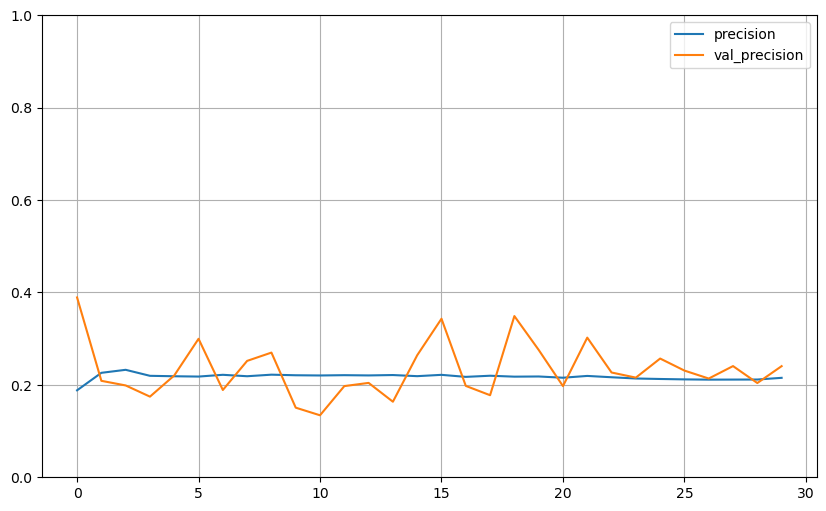

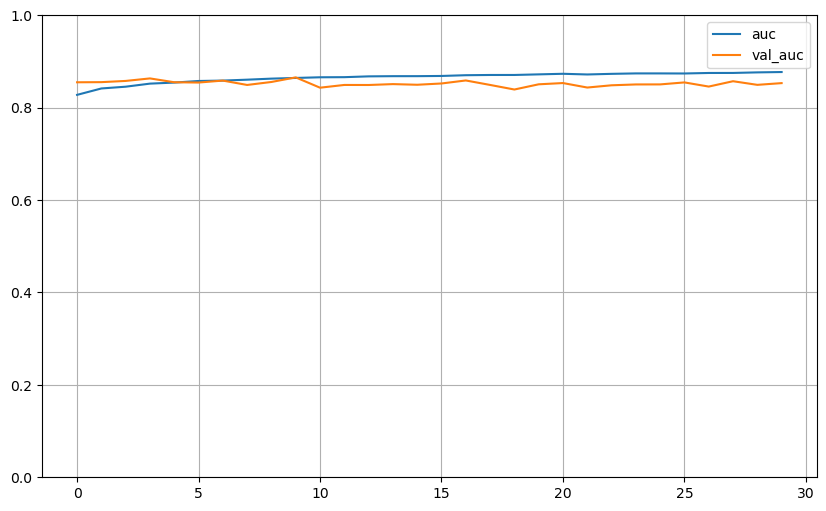

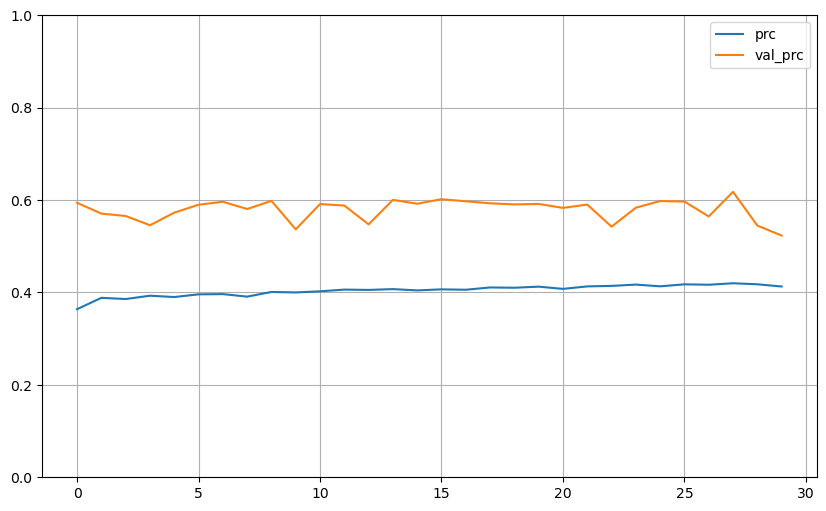

In [40]:
for m in metrics_list:
    plot(history,m)

## Baseline models

#### CNN

In [41]:
cnn_model=build_cnn(TIMESTEPS,FEATURES,OUTPUT)
CNN_history=cnn_model.fit(X_train,y_train,epochs=30,batch_size=32,validation_data=(X_val,y_val),class_weight=class_weight)
cnn_model.evaluate(X_test,y_test)
plot_cm(y_test,clean_preds(cnn_model,X_test))
for m in metrics_list:
    plot(CNN_history,m)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 64)             1984      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 100)               6500      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                        

KeyboardInterrupt: 

#### LSTM

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 4, 128)           38400     
 l)                                                              
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 59,041
Trainable params: 59,041
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
6075/6075 [==============================] - 81s 13ms/step - loss: 0.4587 - accuracy: 0.9182 - precision: 0.2292 - recall: 0.6535 - auc: 0.8298 - prc: 0.3956 - val_loss: 0.4391 - val_accuracy: 0.9269 - val_precision: 0.3521 - val_re

Epoch 26/30
6075/6075 [==============================] - 76s 12ms/step - loss: 0.1284 - accuracy: 0.9385 - precision: 0.3404 - recall: 0.9741 - auc: 0.9860 - prc: 0.6682 - val_loss: 0.3331 - val_accuracy: 0.8900 - val_precision: 0.2437 - val_recall: 0.6813 - val_auc: 0.8393 - val_prc: 0.4447
Epoch 27/30
6075/6075 [==============================] - 76s 12ms/step - loss: 0.1264 - accuracy: 0.9407 - precision: 0.3488 - recall: 0.9747 - auc: 0.9864 - prc: 0.6752 - val_loss: 0.3274 - val_accuracy: 0.8950 - val_precision: 0.2543 - val_recall: 0.6841 - val_auc: 0.8361 - val_prc: 0.4092
Epoch 28/30
6075/6075 [==============================] - 76s 12ms/step - loss: 0.1195 - accuracy: 0.9438 - precision: 0.3616 - recall: 0.9776 - auc: 0.9873 - prc: 0.6870 - val_loss: 0.3193 - val_accuracy: 0.8980 - val_precision: 0.2622 - val_recall: 0.6923 - val_auc: 0.8435 - val_prc: 0.4423
Epoch 29/30
6075/6075 [==============================] - 76s 13ms/step - loss: 0.1149 - accuracy: 0.9459 - precision: 0.3

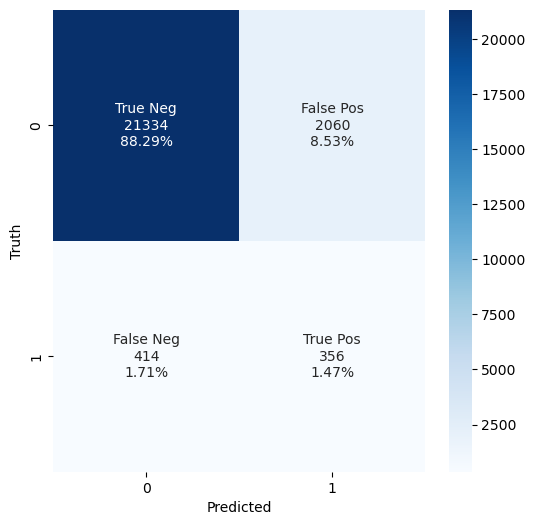

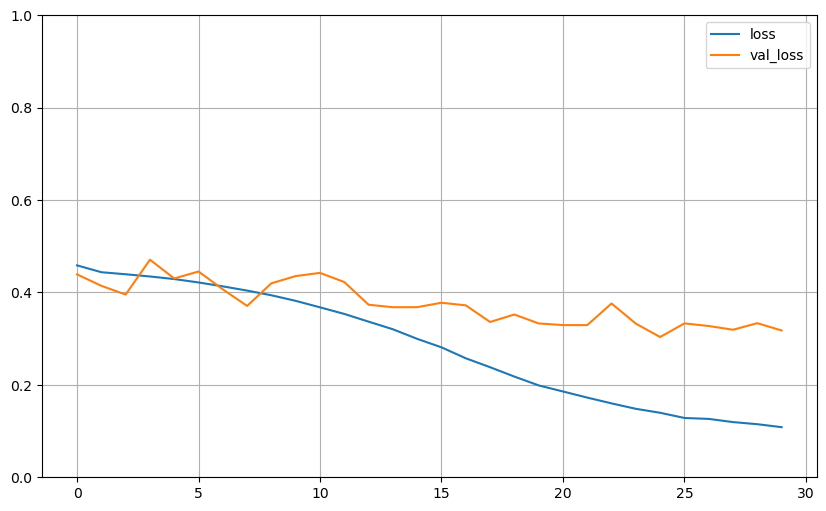

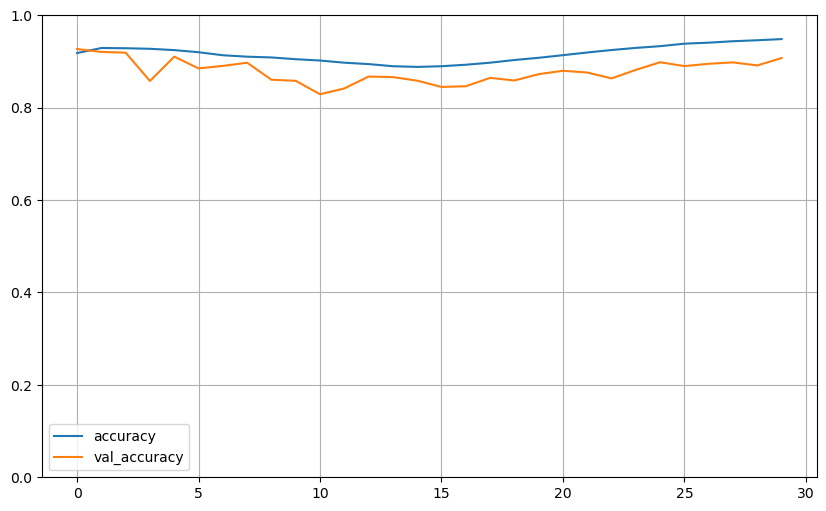

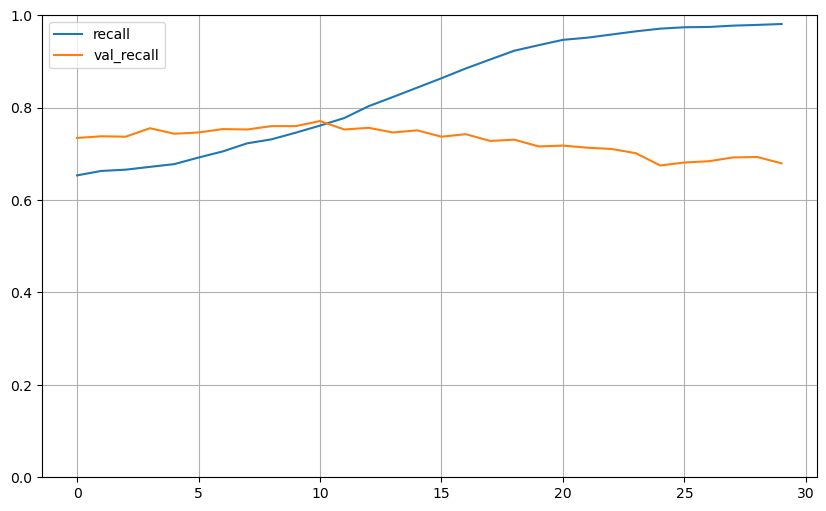

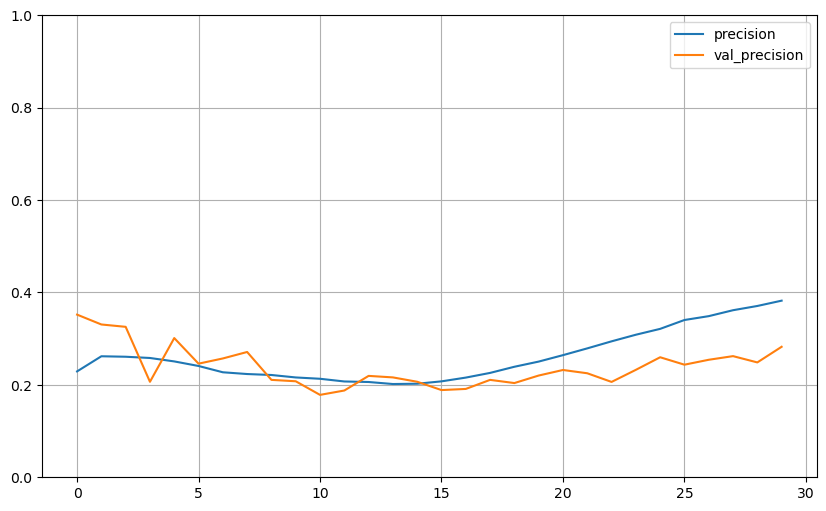

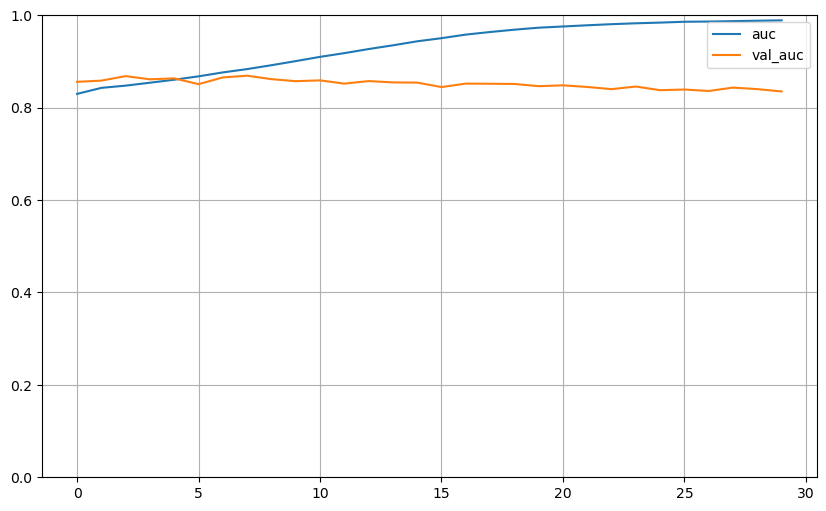

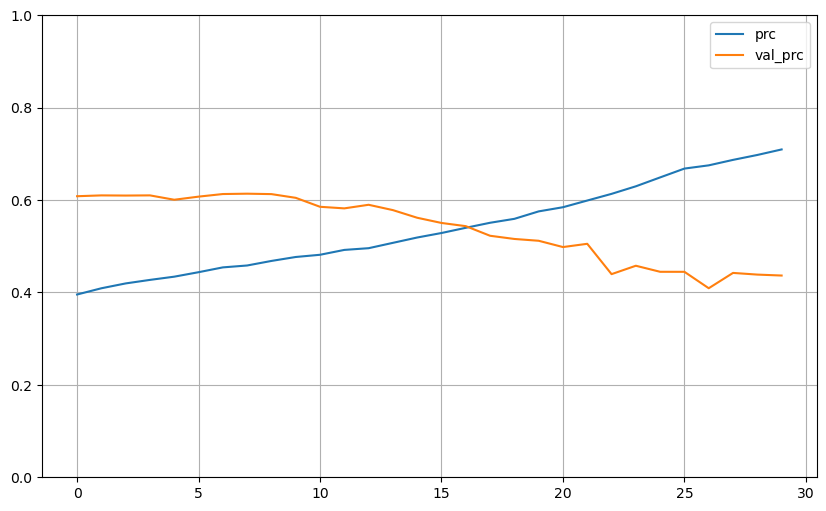

In [42]:
lstm_model=build_lstm(TIMESTEPS,FEATURES,OUTPUT)
lstm_history=lstm_model.fit(X_train,y_train,epochs=30,batch_size=32,validation_data=(X_val,y_val),class_weight=class_weight)
lstm_model.evaluate(X_test,y_test)
plot_cm(y_test,clean_preds(lstm_model,X_test))
for m in metrics_list:
    plot(lstm_history,m)

#### GRU

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 4, 128)           29184     
 l)                                                              
                                                                 
 gru_1 (GRU)                 (None, 32)                15552     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 44,769
Trainable params: 44,769
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
6075/6075 [==============================] - 87s 11ms/step - loss: 0.4590 - accuracy: 0.9194 - precision: 0.2322 - recall: 0.6543 - auc: 0.8283 - prc: 0.3879 - val_loss: 0.4115 - val_accuracy: 0.9263 - val_precision: 0.3500 - val_reca

Epoch 26/30
6075/6075 [==============================] - 67s 11ms/step - loss: 0.1199 - accuracy: 0.9487 - precision: 0.3826 - recall: 0.9728 - auc: 0.9878 - prc: 0.6748 - val_loss: 0.3104 - val_accuracy: 0.9075 - val_precision: 0.2821 - val_recall: 0.6777 - val_auc: 0.8400 - val_prc: 0.4296
Epoch 27/30
6075/6075 [==============================] - 67s 11ms/step - loss: 0.1185 - accuracy: 0.9501 - precision: 0.3892 - recall: 0.9710 - auc: 0.9882 - prc: 0.6893 - val_loss: 0.3177 - val_accuracy: 0.9006 - val_precision: 0.2629 - val_recall: 0.6648 - val_auc: 0.8296 - val_prc: 0.3427
Epoch 28/30
6075/6075 [==============================] - 67s 11ms/step - loss: 0.1163 - accuracy: 0.9508 - precision: 0.3929 - recall: 0.9733 - auc: 0.9885 - prc: 0.6912 - val_loss: 0.3230 - val_accuracy: 0.9029 - val_precision: 0.2693 - val_recall: 0.6703 - val_auc: 0.8363 - val_prc: 0.4093
Epoch 29/30
6075/6075 [==============================] - 67s 11ms/step - loss: 0.1114 - accuracy: 0.9526 - precision: 0.4

NameError: name 'metrics_list' is not defined

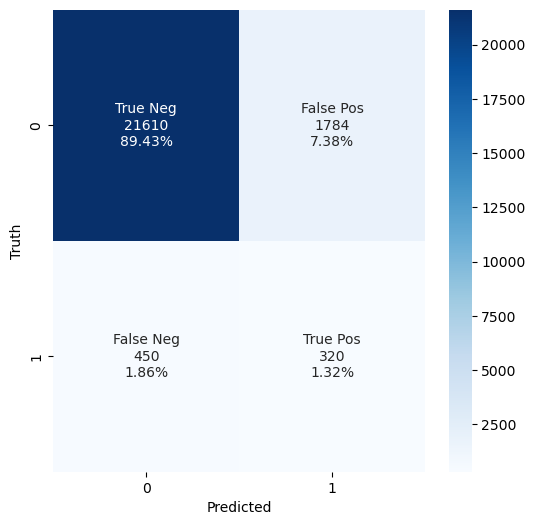

In [18]:
gru_model=build_gru(TIMESTEPS,FEATURES,OUTPUT)
gru_history=gru_model.fit(X_train,y_train,epochs=30,batch_size=32,validation_data=(X_val,y_val),class_weight=class_weight)
plot_cm(y_test,clean_preds(gru_model,X_test))
gru_model.evaluate(X_test,y_test)


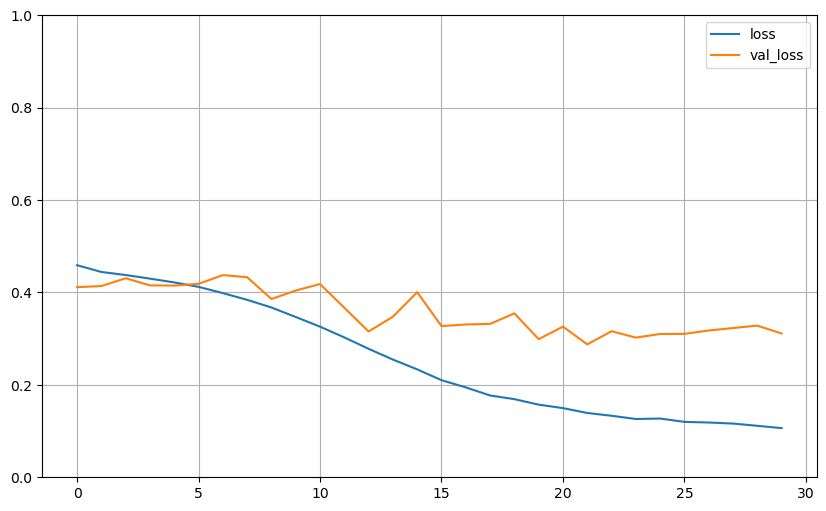

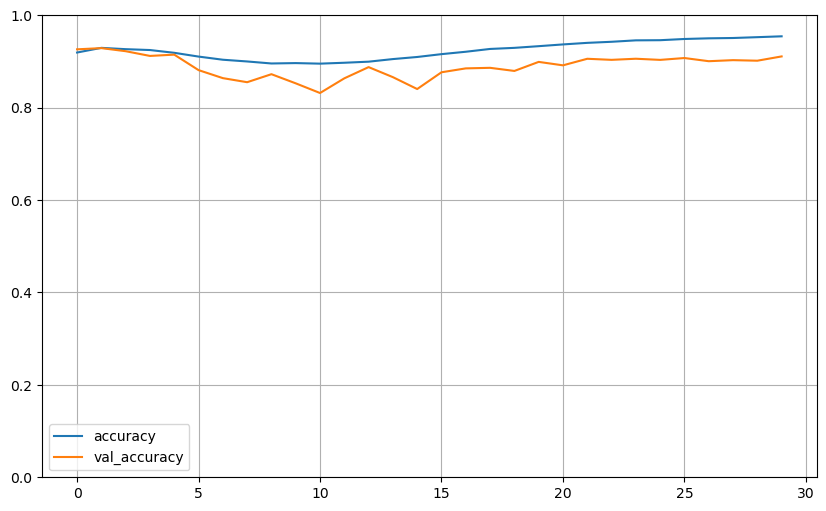

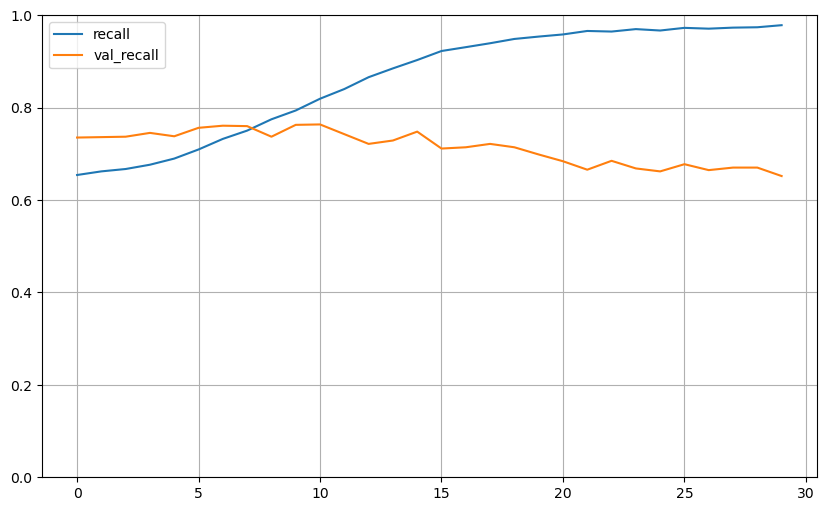

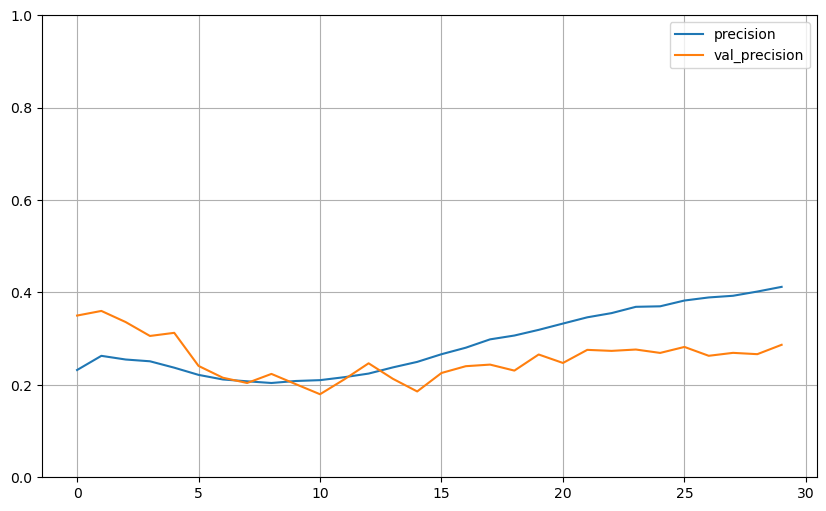

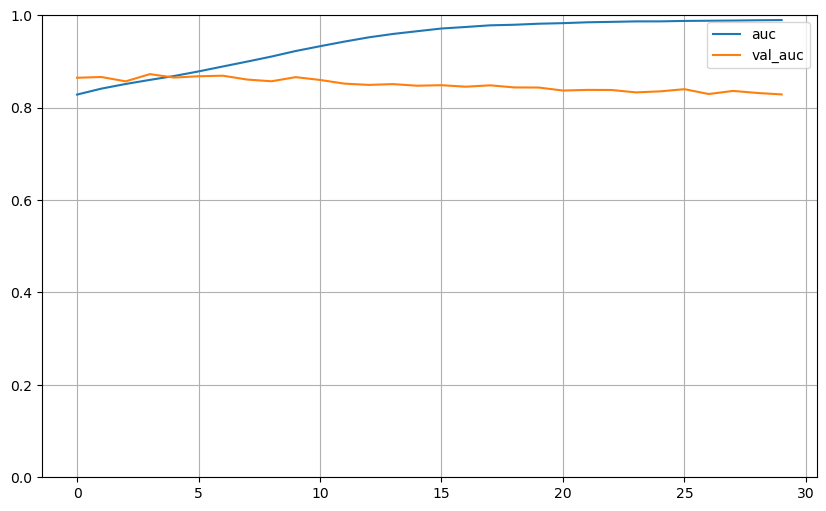

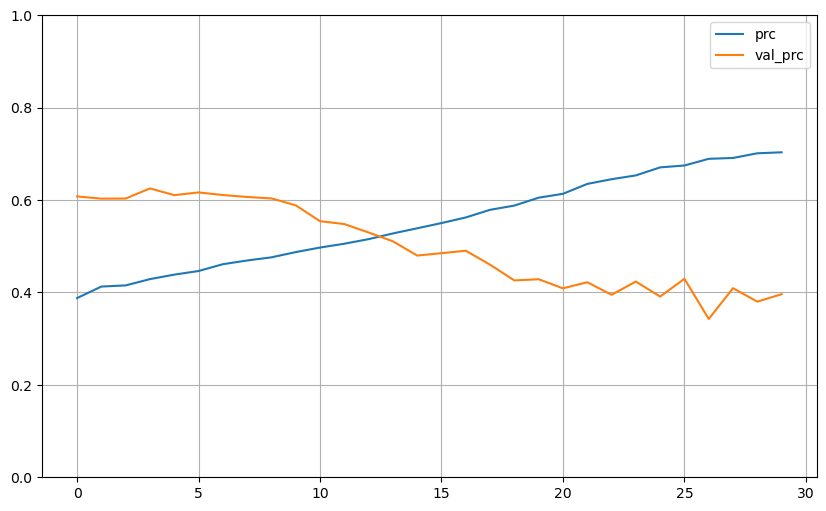

In [20]:
for m in metrics_list:
    plot(gru_history,m)